In [1]:
from obspy.core import Stream, read
import numpy as np
from pytensor.compile.ops import as_op
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import pandas as pd
import os 
import os.path
import pymc as pm
import arviz as az

In [2]:
# What exactly are the colunns here? Amplitude of waves at a specific time?
# My equivalent = peak strain at a specific time

# Build the target function, misfit to this is what is being minimized
@as_op(itypes=[pt.dvector,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar], otypes=[pt.dvector]) # input variable types and output variable type(s)
def two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    # Output vector
    y_out = np.ones(len(x))
    
    # Before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    # Build first straight line segment
    y_out = m1*x + b1
    
    # Find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    # Define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    # print(b2)
    
    # Make second straight line
    y_out[i] = m2*x[i] + b2

    return y_out

# Build the target function, misfit to this is what is being minimized
def non_pytensor_two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    # Output vector
    yout = np.ones(len(x))
    
    # Before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    # Build first straight line segment
    yout = m1*x + b1
    
    # Find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    # Define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    
    # Make second straight line
    yout[i] = m2*x[i] + b2

    return yout

In [3]:
path = '/Users/sydneydybing/StrainProject/2024/taiwan_strain_data/'
events = pd.read_csv(path + 'events_csv.csv')
snr_array = pd.read_csv(path + 'station_data_hypdists_snrs_uncaldata.csv')
snr_array

,Sta,Lat,Lon,Depth(m),2009_hyp_dist_km,2013_hyp_dist_km,2018_hyp_dist_km,snrs_2009,snrs_2013,snrs_2018
0,BCWB,24.2184,121.6891,-192,69.496535,74.182696,7.066640,-,-,-
1,TRKB,24.1614,121.6127,-192,61.088805,65.767547,9.697232,-,1152.21068792,3719.11498193
2,NTTB,24.1728,121.5259,-175,60.587926,65.180780,18.587874,270.716246698,-,-
3,SJNB,24.1073,121.6006,-193,54.988063,59.668808,12.226300,-,1534.07980394,130.500720293
4,HGSB,23.4903,121.4237,-266,15.739505,11.125139,79.319331,643.761404319,439.289700698,372.02315898
5,CHMB,23.4868,121.4703,-191,15.969342,11.924641,78.079695,-,348.253432719,40.3375273883
6,SSNB,23.4423,121.3981,-185,21.504342,16.833483,85.224271,-,766.890944463,129.022087472
7,ZANB,23.3947,121.4585,-218,26.068219,21.740867,88.175343,518.690744579,3295.29308104,106.461483121
8,FBRB,23.1406,121.2796,-200,56.994188,52.307853,120.756809,63.9759287277,410.302431106,80.3549037178
9,SSTB,23.1340,121.3782,-199,55.447392,50.858196,118.191393,-,359.179108909,47.0874813332


In [4]:
events

,evt_id,origin_time,lat,lon,depth
0,2009-10-03_M6.1,2009-10-03T17:36:06.120,23.630,121.452,28.0
1,2013-10-31_M6.3,2013-10-31T12:02:08.720,23.590,121.437,10.0
2,2018-02-04_M6.1,2018-02-04T13:56:41.950,24.157,121.708,12.0


In [5]:
events_list = []
mags_list = []
stas_list = []
hypdist_list = []
xhighs_list = []
m1s_list = []
m2s_list = []
xinters_list = []
sigmas_list = []
trans_time_list = []

for ii in range(len(events)):
    
    evt_id = events['evt_id'][ii]
    print(evt_id)

    for idx in range(len(snr_array)):

        sta = snr_array['Sta'][idx]
        
        # Figure out the bounds for the MCMC based on the event and hypocentral distance (rainbow plots)
        xlow = 10
        
        if evt_id == '2009-10-03_M6.1':
            mag = '6.1'
            hypdist = snr_array['2009_hyp_dist_km'][idx]
            if sta == 'ZANB':
                xhigh = 17
            elif sta == 'NTTB' or sta == 'HGSB':
                xhigh = 22
            elif sta == 'FBRB':
                xhigh = 29
        elif evt_id == '2013-10-31_M6.3':
            mag = '6.3'
            hypdist = snr_array['2013_hyp_dist_km'][idx]
            if sta == 'FBRB' or sta == 'SSTB' or sta == 'DONB':
                xhigh = 30
            elif sta == 'HGSB' or sta == 'CHMB' or sta == 'ZANB':
                xhigh = 20
            elif sta == 'TRKB' or sta == 'SJNB':
                xhigh = 25
            elif sta == 'SSNB':
                xhigh = 15
            else:
                print('2013 sta typo ' + str(sta))
        elif evt_id == '2018-02-04_M6.1':
            mag = '6.1'
            hypdist = snr_array['2018_hyp_dist_km'][idx]
            if sta == 'TRKB' or sta == 'SJNB':
                xhigh = 13
            elif sta == 'HGSB' or sta == 'CHMB' or sta == 'SSNB' or sta == 'ZANB':
                xhigh = 35
            elif sta == 'FBRB' or sta == 'SSTB':
                xhigh = 55
            else:
                print('2018 sta typo ' + str (sta))
        
        int_hypdist = int(hypdist)
        
        # if evt_id == '2013-10-31_M6.3' and sta == 'SSNB' or sta == 'SSTB':
        #     pass
        # elif evt_id == '2018-02-04_M6.1' and sta == 'TRKB':
        #     pass
        # else:
        #     continue
        
        try:
            pst = read(path + 'filtered_abs_peak_post_p_uncal/' + evt_id + '/' + sta + '.mseed')
        except:
            print('Skipping ' + sta + ', no data')
            continue

        print('Processing ' + str(sta))
        
        times = pst[0].times()
        data = pst[0].data
        log10_data = np.log10(data)
        samp_rate = pst[0].stats.sampling_rate
        print(samp_rate)
        
        vec_start = int(xlow*samp_rate)
        vec_end = int(xhigh*samp_rate)

        # Split into x and y vectors
        xobserved = times[vec_start:vec_end]
        yobserved = log10_data[vec_start:vec_end]
        x0 = xobserved[0]
        y0 = yobserved[0]
        
        # in order to pass the x variable into the target function it needs to be 
        # converted to a Theano "shared" variable
        pt_xobserved = pytensor.shared(xobserved)
        pt_x0 = pytensor.shared(x0)
        pt_y0 = pytensor.shared(y0)
            
        # MCMC run parameters, these are good numbers for a "production" run. If you are
        # fooling arund these can be lower to iterate faster
        Nburn = 5000 # burn in samples that get discarded
        Nmcmc = 15000 # bump to at least 5-10k
        Nchains = 4
        Ncores = 1
        
        # Bounds for the prior distributions
        m1_low = -1; m1_high = 20
        m2_low = -1; m2_high = 3
        xinter_low = 10 ; xinter_high = 25 # location of the line slope change
        
        # Define the Bayesian model
        with pm.Model()as model:
            
            # Use normal distributions as priors
            m1 = pm.Uniform('m1', lower = m1_low, upper = m1_high)
            m2 = pm.Uniform('m2', lower = m2_low, upper = m2_high)
            # m1 = pm.Normal('m1', mu = 0.5, sigma = 1)
            # m2 = pm.Normal('m2', mu = -0.1, sigma = 5)
            xinter = pm.Uniform('xinter', lower = xinter_low, upper = xinter_high)
            sigma = pm.HalfCauchy('sigma', beta = 10, initval = 1)
        
            # This is the model
            likelihood = pm.Normal('y', mu = two_straight_lines(pt_xobserved,m1,m2,xinter,pt_x0,pt_y0),
                                    observed = yobserved, sigma = sigma)

            # NUTS sampler (default) is gradient based and won't work, use metropolis
            step = pm.Metropolis(scaling = 0.1)
            
            # This runs the mcmc sampler
            mcmc = pm.sample(Nmcmc, tune = Nburn, chains = Nchains, cores = Ncores, step = step)
        
        # Done, now is post-processing to get the data out of the sampler

        posterior = az.extract(mcmc)
        
        # Unwrap coeficients - WRITE LINES TO SAVE THE ARRAYS!!!
        m1_array = posterior.m1.values
        m1 = np.mean(m1_array)
        # print('m1 mean: ' + str(round(m1,2)))
        
        m2_array = posterior.m2.values
        m2 = np.mean(m2_array)
        # print('m2 mean: ' + str(round(m2,2)))
        
        xinter_array = posterior.xinter.values
        xinter = np.mean(xinter_array)
        # print('xinter Mean: ' + str(round(xinter,2)))
        
        sigma_array = posterior.sigma.values
        sigma = np.mean(sigma_array)

        # Lines!
        b1 = y0 - m1*x0
        b2 = m1*xinter + b1 - m2*xinter
        
        # Make plot to check stuff
        xpredicted = np.arange(xobserved.min(), xobserved.max()+0.1, 0.1)
        ypredicted = m1*xpredicted + b1
        i = np.where(xpredicted > xinter)[0]
        ypredicted[i] = m2*xpredicted[i] + b2
        
        # Get one-sigma region (need to obtain a ton of forward models and get stats)
        N = len(posterior.m1.values)
        
        yfit = np.zeros((len(xpredicted), N))
        for k in range(N):
            yfit[:,k] = non_pytensor_two_straight_lines(xpredicted,m1_array[k],m2_array[k],xinter_array[k],x0,y0)
        mu = yfit.mean(1)
        sig = yfit.std(1) * 1.95 #for 95% confidence
        mu_plus = mu + sig
        mu_minus = mu - sig
        
        # Least squares
        mls, bls = np.polyfit(xobserved, yobserved, 1)
        
        # Find the transition point in ypredicted
        diff = np.round(np.diff(ypredicted), decimals = 5)
        # print(diff)
        first_slope = diff[0]
        second_slope = diff[-1]
        trans_idx = np.where((diff != first_slope) & (diff != second_slope))[0][0] + 1
        
        # Get the transition point
        mcmc_trans_x = xpredicted[trans_idx] # Number
        mcmc_trans_y = ypredicted[trans_idx]
        
        # Append things
        events_list.append(evt_id)
        mags_list.append(mag)
        stas_list.append(sta)
        hypdist_list.append(int_hypdist)
        xhighs_list.append(xhigh)
        m1s_list.append(m1)
        m2s_list.append(m2)
        xinters_list.append(xinter)
        sigmas_list.append(sigma)
        trans_time_list.append(mcmc_trans_x)
        
        # Create folder for the event
        array_save_dir = path + 'mcmc_arrays_uncal/' + evt_id + '/' + sta + '/'
        if os.path.isdir(array_save_dir):
            pass
        else:
            os.makedirs(array_save_dir)

        np.save(array_save_dir + 'xobserved.npy', xobserved)
        np.save(array_save_dir + 'yobserved.npy', yobserved)
        np.save(array_save_dir + 'xpredicted.npy', xpredicted)
        np.save(array_save_dir + 'ypredicted.npy', ypredicted)
        np.save(array_save_dir + 'forward_mus.npy', mu)
        np.save(array_save_dir + 'foward_sigs.npy', sig)
        
        summary = az.summary(mcmc, fmt = 'wide')
        print(summary)
        summary.to_csv(array_save_dir + 'mcmc_summary.csv', index = False)
        
        # Folder for figures
        fig_save_dir = path + 'mcmc_plots_uncal/' + evt_id + '/'
        if os.path.isdir(fig_save_dir):
            pass
        else:
            os.makedirs(fig_save_dir)
        
        az.plot_trace(mcmc)
        # plt.show()
        plt.savefig(fig_save_dir + sta + '_stats_plots.png', format = 'PNG')
        plt.close()

        # Plot all solutions
        fig = plt.figure(dpi = 100)
        ax = fig.add_subplot(111)
        ax.set_title(str(sta))
        
        ax.plot(xobserved, yobserved, color = 'blue', label = 'Observed (log peak strain)')
        ax.plot(xpredicted, ypredicted, color = 'red', label = 'Predicted (MCMC)')
        # ax.plot(xpredicted, mu, color = 'green', linestyle = '--', label = 'yfit')
        # ax.plot(xpredicted, xpredicted * mls + bls, color = 'orange', label = 'np.polyfit least squares')
        ax.scatter(xpredicted[trans_idx], ypredicted[trans_idx], marker = 'o', color = 'black', label = 'Transition at ' + str(round(xpredicted[trans_idx],2)) + ' sec')
        # ax.scatter(closest_trans_x, closest_trans_y, marker = 'o', color = 'green', label = 'Adjusted transition at ' + str(round(closest_trans_x,2)) + ' sec')
        # ax2 = ax.twinx()
        # ax2.plot(xobserved, pythags_arr, color = 'violet')
        # ax2.axhline(closest_trans_x, color = 'violet', linestyle = '--')
        ax.fill_between(xpredicted, mu_plus, mu_minus, color = 'gray', alpha = 0.2, label = '95% confidence') # 95% confidence interval
        ax.set_xlabel('Time (s) - p-wave at 10s')
        ax.set_ylabel('log10 of peak strain')
        # ax.set_xlim(10,13)
        ax.legend()
        
        # plt.show()
            
        plt.savefig(fig_save_dir + sta + '.png', format = 'PNG')
        plt.close()

2009-10-03_M6.1
Skipping BCWB, no data
Skipping TRKB, no data
Processing NTTB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 220 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.950  0.460   4.180    5.688      0.215    0.164       5.0   
m2       0.103  0.002   0.099    0.105      0.001    0.000       9.0   
xinter  10.484  0.050  10.414   10.573      0.023    0.017       5.0   
sigma    0.097  0.006   0.088    0.111      0.003    0.002       6.0   

        ess_tail  r_hat  
m1          23.0   2.43  
m2          39.0   1.39  
xinter      23.0   2.43  
sigma       32.0   1.72  
Skipping SJNB, no data
Processing HGSB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 212 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.839  0.213   3.462    4.197      0.100    0.076       5.0   
m2       0.093  0.003   0.088    0.098      0.001    0.001       7.0   
xinter  10.888  0.056  10.796   10.988      0.026    0.020       5.0   
sigma    0.170  0.005   0.162    0.178      0.001    0.001      14.0   

        ess_tail  r_hat  
m1          22.0   2.48  
m2          21.0   1.55  
xinter      22.0   2.49  
sigma       33.0   1.20  
Skipping CHMB, no data
Skipping SSNB, no data
Processing ZANB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 205 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       6.954  0.293   6.463    7.537      0.120    0.090       6.0   
m2       0.106  0.004   0.098    0.114      0.001    0.001      15.0   
xinter  10.436  0.020  10.397   10.470      0.008    0.006       6.0   
sigma    0.172  0.005   0.163    0.180      0.000    0.000     396.0   

        ess_tail  r_hat  
m1          13.0   1.81  
m2         152.0   1.19  
xinter      14.0   1.84  
sigma     5673.0   1.01  
Processing FBRB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 225 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.829  0.121   1.593    2.031      0.056    0.043       5.0   
m2       0.045  0.001   0.042    0.047      0.001    0.000       7.0   
xinter  11.323  0.107  11.169   11.532      0.048    0.037       5.0   
sigma    0.143  0.004   0.136    0.151      0.002    0.001      10.0   

        ess_tail  r_hat  
m1          11.0   2.79  
m2          10.0   1.58  
xinter      12.0   2.77  
sigma       11.0   1.31  
Skipping SSTB, no data
Skipping DONB, no data
2013-10-31_M6.3
2013 sta typo BCWB
Skipping BCWB, no data
Processing TRKB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 217 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.070  0.033   2.006    2.127      0.013    0.009       7.0   
m2       0.069  0.001   0.066    0.071      0.000    0.000     127.0   
xinter  11.306  0.023  11.269   11.356      0.009    0.007       7.0   
sigma    0.189  0.003   0.183    0.196      0.000    0.000    9071.0   

        ess_tail  r_hat  
m1          22.0   1.55  
m2         281.0   1.04  
xinter      23.0   1.53  
sigma     9025.0   1.00  
2013 sta typo NTTB
Skipping NTTB, no data
Processing SJNB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 179 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.152  0.068   2.019    2.276      0.031    0.023       5.0   
m2       0.085  0.001   0.083    0.087      0.000    0.000       9.0   
xinter  11.214  0.044  11.136   11.302      0.020    0.015       5.0   
sigma    0.149  0.003   0.144    0.155      0.000    0.000      66.0   

        ess_tail  r_hat  
m1          22.0   2.26  
m2          47.0   1.35  
xinter      22.0   2.26  
sigma      221.0   1.04  
Processing HGSB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 166 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       6.131  0.947   5.057    8.083      0.466    0.357       5.0   
m2       0.084  0.002   0.080    0.088      0.001    0.001       8.0   
xinter  10.345  0.049  10.249   10.409      0.024    0.018       5.0   
sigma    0.124  0.004   0.118    0.131      0.001    0.001      13.0   

        ess_tail  r_hat  
m1          18.0   2.55  
m2          24.0   1.53  
xinter      18.0   2.56  
sigma       63.0   1.21  
Processing CHMB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 168 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1      10.010  1.356   7.742   12.155      0.638    0.489       5.0   
m2       0.079  0.001   0.076    0.081      0.000    0.000      27.0   
xinter  10.196  0.029  10.157   10.248      0.013    0.010       5.0   
sigma    0.096  0.006   0.088    0.109      0.002    0.002       7.0   

        ess_tail  r_hat  
m1          18.0   2.42  
m2         116.0   1.11  
xinter      18.0   2.42  
sigma       37.0   1.60  
Processing SSNB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 165 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       8.023  1.296   6.887    8.843      0.451    0.373       7.0   
m2       0.255  0.227   0.223    0.236      0.033    0.023     275.0   
xinter  10.417  1.471  10.187   10.245      0.294    0.210       7.0   
sigma    0.112  0.101   0.087    0.105      0.024    0.017      18.0   

        ess_tail  r_hat  
m1          11.0   1.63  
m2          90.0   1.06  
xinter      11.0   1.61  
sigma       11.0   1.15  
Processing ZANB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 1188 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1      16.251  2.802  11.573   19.998      1.323    1.022       5.0   
m2       0.064  0.002   0.060    0.067      0.001    0.000       8.0   
xinter  10.178  0.034  10.138   10.244      0.015    0.012       5.0   
sigma    0.106  0.018   0.084    0.144      0.008    0.006       5.0   

        ess_tail  r_hat  
m1          28.0   2.41  
m2          36.0   1.48  
xinter      28.0   2.42  
sigma       27.0   2.34  
Processing FBRB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 166 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.737  0.143   1.517    2.007      0.069    0.052       4.0   
m2       0.077  0.001   0.075    0.079      0.000    0.000       7.0   
xinter  11.146  0.101  10.963   11.316      0.049    0.037       4.0   
sigma    0.119  0.003   0.114    0.124      0.001    0.001      10.0   

        ess_tail  r_hat  
m1          11.0   3.25  
m2          14.0   1.63  
xinter      11.0   3.23  
sigma       28.0   1.31  
Processing SSTB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 162 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       7.305  3.437   3.867   14.163      1.696    1.299       5.0   
m2       0.075  0.001   0.073    0.076      0.000    0.000       9.0   
xinter  10.358  0.134  10.151   10.565      0.064    0.049       5.0   
sigma    0.130  0.025   0.091    0.170      0.012    0.009       5.0   

        ess_tail  r_hat  
m1          15.0   2.68  
m2          66.0   1.37  
xinter      16.0   2.68  
sigma       20.0   2.45  
Processing DONB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 152 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.040  0.051   0.946    1.129      0.015    0.011      11.0   
m2       0.077  0.002   0.074    0.080      0.000    0.000     140.0   
xinter  11.401  0.079  11.258   11.545      0.023    0.017      11.0   
sigma    0.162  0.006   0.151    0.173      0.000    0.000   13348.0   

        ess_tail  r_hat  
m1          34.0   1.30  
m2         164.0   1.03  
xinter      41.0   1.29  
sigma    14599.0   1.00  
2018-02-04_M6.1
2018 sta typo BCWB
Skipping BCWB, no data
Processing TRKB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 142 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1      10.035  1.100   8.014   12.273      0.133    0.095      71.0   
m2       0.626  0.029   0.573    0.679      0.001    0.001    1026.0   
xinter  10.173  0.021  10.132   10.213      0.002    0.002      70.0   
sigma    0.172  0.017   0.141    0.204      0.000    0.000    6003.0   

        ess_tail  r_hat  
m1         119.0   1.04  
m2        2624.0   1.00  
xinter     121.0   1.04  
sigma     9333.0   1.00  
2018 sta typo NTTB
Skipping NTTB, no data
Processing SJNB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 144 seconds.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.651  0.073   1.516    1.790      0.004    0.003     409.0   
m2       0.404  0.024   0.357    0.450      0.001    0.000    1325.0   
xinter  10.670  0.046  10.586   10.761      0.002    0.002     413.0   
sigma    0.110  0.011   0.092    0.131      0.000    0.000    6988.0   

        ess_tail  r_hat  
m1         823.0   1.01  
m2        2448.0   1.01  
xinter     771.0   1.01  
sigma     9764.0   1.00  
Processing HGSB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 150 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.957  0.165   1.591    2.200      0.071    0.053       6.0   
m2       0.043  0.001   0.040    0.045      0.000    0.000      24.0   
xinter  11.220  0.121  11.054   11.499      0.053    0.040       6.0   
sigma    0.183  0.006   0.172    0.195      0.001    0.000      99.0   

        ess_tail  r_hat  
m1          11.0   1.70  
m2          36.0   1.12  
xinter      11.0   1.70  
sigma      372.0   1.03  
Processing CHMB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 145 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.668  0.012   0.642    0.686      0.003    0.002      17.0   
m2       0.050  0.001   0.049    0.051      0.000    0.000      96.0   
xinter  12.196  0.047  12.113   12.285      0.011    0.008      19.0   
sigma    0.095  0.003   0.089    0.101      0.000    0.000   12606.0   

        ess_tail  r_hat  
m1          33.0   1.16  
m2         140.0   1.03  
xinter      33.0   1.15  
sigma    13207.0   1.00  
Processing SSNB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 146 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.384  0.066   1.253    1.491      0.022    0.016       9.0   
m2       0.055  0.001   0.053    0.057      0.000    0.000      44.0   
xinter  11.255  0.065  11.152   11.393      0.022    0.016       9.0   
sigma    0.148  0.005   0.138    0.156      0.000    0.000   12137.0   

        ess_tail  r_hat  
m1          16.0   1.39  
m2          98.0   1.07  
xinter      15.0   1.40  
sigma    12944.0   1.00  
Processing ZANB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 146 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.877  0.187   1.594    2.212      0.089    0.067       5.0   
m2       0.040  0.001   0.039    0.041      0.000    0.000      14.0   
xinter  10.802  0.079  10.668   10.937      0.037    0.028       5.0   
sigma    0.080  0.003   0.074    0.085      0.000    0.000      32.0   

        ess_tail  r_hat  
m1          20.0   2.45  
m2          63.0   1.20  
xinter      20.0   2.44  
sigma      168.0   1.08  
Processing FBRB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 1914 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.922  0.278   1.514    2.299      0.137    0.105       5.0   
m2       0.026  0.001   0.025    0.028      0.000    0.000       7.0   
xinter  11.583  0.249  11.282   11.987      0.122    0.093       5.0   
sigma    0.163  0.006   0.153    0.174      0.002    0.002       8.0   

        ess_tail  r_hat  
m1          11.0   2.89  
m2          26.0   1.65  
xinter      11.0   2.89  
sigma       31.0   1.43  
Processing SSTB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 3217 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.109  0.248   0.822    1.586      0.118    0.090       5.0   
m2       0.019  0.001   0.019    0.021      0.000    0.000       6.0   
xinter  11.556  0.322  11.011   12.021      0.157    0.120       5.0   
sigma    0.107  0.008   0.097    0.124      0.004    0.003       6.0   

        ess_tail  r_hat  
m1          19.0   2.89  
m2          32.0   1.84  
xinter      19.0   2.88  
sigma       25.0   1.83  
2018 sta typo DONB
Skipping DONB, no data


In [6]:
mcmc_array = np.column_stack((np.array(events_list), np.array(mags_list), np.array(stas_list), np.array(hypdist_list),
                             np.array(xhighs_list), np.array(m1s_list), np.array(m2s_list), np.array(xinters_list),
                             np.array(sigmas_list), np.round(np.array(trans_time_list),2)))

mcmc_array

array([['2009-10-03_M6.1', '6.1', 'NTTB', '60', '22',
        '4.9502493859495695', '0.10310653908022012',
        '10.484332182422119', '0.09739020960897214', '10.5'],
       ['2009-10-03_M6.1', '6.1', 'HGSB', '15', '22',
        '3.838528488647018', '0.09339938300001992', '10.887917388409642',
        '0.1695959816232343', '10.9'],
       ['2009-10-03_M6.1', '6.1', 'ZANB', '26', '17', '6.95358790764413',
        '0.10642349222042281', '10.43638870451086',
        '0.17170826122439106', '10.5'],
       ['2009-10-03_M6.1', '6.1', 'FBRB', '56', '29',
        '1.828761727283066', '0.045035495845760755',
        '11.322538201978448', '0.14300311863352472', '11.4'],
       ['2013-10-31_M6.3', '6.3', 'TRKB', '65', '25',
        '2.0700503693892407', '0.06883758375353913',
        '11.306140211214315', '0.18908075594404722', '11.4'],
       ['2013-10-31_M6.3', '6.3', 'SJNB', '59', '25',
        '2.152219029581015', '0.08494056473087942', '11.213510446446643',
        '0.14927883053985103', '

In [7]:
# # Insert the re-run stations into the results array

# old_mcmc_array = np.load(path + 'mcmc_arrays/mcmc_colstack_array.npy')
# print(old_mcmc_array.shape)

# ssnb13 = np.where((old_mcmc_array[:,0] == '2013-10-31_M6.3') & (old_mcmc_array[:,2] == 'SSNB'))[0]
# # print(old_mcmc_array[ssnb13])
# sstb13 = np.where((old_mcmc_array[:,0] == '2013-10-31_M6.3') & (old_mcmc_array[:,2] == 'SSTB'))[0]
# # print(old_mcmc_array[sstb13])
# trkb18 = np.where((old_mcmc_array[:,0] == '2018-02-04_M6.1') & (old_mcmc_array[:,2] == 'TRKB'))[0]
# # print(old_mcmc_array[trkb18])

# del_array = np.delete(old_mcmc_array, [ssnb13, sstb13, trkb18], axis = 0)
# print(del_array.shape)

# ins_array = np.insert(del_array, ssnb13, mcmc_array[0], axis = 0)
# ins_array = np.insert(ins_array, sstb13, mcmc_array[1], axis = 0)
# ins_array = np.insert(ins_array, trkb18, mcmc_array[2], axis = 0)
# print(ins_array.shape)

# # pd_old = pd.DataFrame(old_mcmc_array)
# # pd_ins = pd.DataFrame(ins_array)

# np.save(path + 'mcmc_arrays/mcmc_colstack_array.npy', ins_array)

In [8]:
mcmc_array = np.column_stack((np.array(events_list), np.array(mags_list), np.array(stas_list), np.array(hypdist_list),
                             np.array(xhighs_list), np.array(m1s_list), np.array(m2s_list), np.array(xinters_list),
                             np.array(sigmas_list), np.round(np.array(trans_time_list),2)))

np.save(path + 'mcmc_arrays_uncal/mcmc_colstack_array.npy', mcmc_array)

In [9]:
taiwan_mcmc_array = np.load(path + 'mcmc_arrays_uncal/mcmc_colstack_array.npy')
taiwan_mcmc_array.shape

# Columns:
# 0. Event name
# 1. Magnitude
# 2. Station name
# 3. Hypocentral distance (km)
# 4. xhigh
# 5. m1 slope
# 6. m2 slope
# 7. intersection point
# 8. sigma
# 9. transition time

(21, 10)

In [12]:
na_mcmc_array = np.load('/Users/sydneydybing/StrainProject/2024/filtered_mcmc_arrays/summary_array.npy')
na_mcmc_array.shape

(211, 10)

In [13]:
tohoku = pd.read_csv('/Users/sydneydybing/StrainProject/2024/tohoku_strain_data/stations_hypdists_snrs_flatsecs.list')
# tohoku
tohoku_mcmc_array = np.load('/Users/sydneydybing/StrainProject/2024/tohoku_strain_data/mcmc_arrays/mcmc_colstack_array.npy')
tohoku_mcmc_array.shape

(8, 10)

In [14]:
# Calculate earthquake source durations

# Get M0 from Mw, then use relation in Melgar and Hayes, 2017 to get duration

mags_for_relation = np.arange(6,9.25,0.25)
# print(mags_for_dur)

# Preferred params for source duration
apref_sd = -6.407
bpref_sd = 0.385

apref_rt = -5.323
bpref_rt = 0.293

source_durs = []
rise_times = []

for Mw in mags_for_relation:
    
    M0 = 10**(1.5*Mw + 9.05)
    # print(M0)
    
    log_sd = apref_sd + bpref_sd * np.log10(M0)
    source_dur = 10**log_sd
    source_durs.append(source_dur)
    
    log_rt = apref_rt + bpref_rt * np.log10(M0)
    rise_time = 10**log_rt
    rise_times.append(rise_time)
    

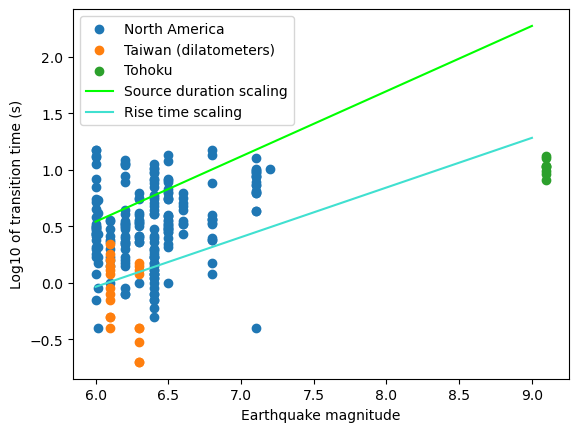

In [15]:
plt.scatter(na_mcmc_array[:,1].astype(float), np.log10(na_mcmc_array[:,9].astype(float)-10), label = 'North America')
plt.scatter(taiwan_mcmc_array[:,1].astype(float), np.log10(taiwan_mcmc_array[:,9].astype(float)-10), label = 'Taiwan (dilatometers)')
plt.scatter(tohoku_mcmc_array[:,1].astype(float), np.log10(tohoku_mcmc_array[:,9].astype(float)-10), label = 'Tohoku')
plt.plot(mags_for_relation, np.log10(source_durs), color = 'lime', label = 'Source duration scaling')
plt.plot(mags_for_relation, np.log10(rise_times), color = 'turquoise', label = 'Rise time scaling')
plt.xlabel('Earthquake magnitude')
plt.ylabel('Log10 of transition time (s)')
plt.legend(loc = 'upper left');

In [232]:
# Get mean transition time by event

# North America

na_unique_eventids = np.unique(na_mcmc_array[:,0])

na_mags = []
na_mean_trans_times = []

for uni_id in na_unique_eventids:
    
    print(uni_id)
    i = np.where(uni_id == na_mcmc_array[:,0])[0]
    # print(i)
    
    trans_times = na_mcmc_array[i,9].astype(float)-10
    mag = na_mcmc_array[i,1].astype(float)[0]
    # print(mags)
    print(trans_times)
    
    mean_trans_time = np.mean(trans_times)
    # print(mean_trans_time)
    
    na_mags.append(mag)
    na_mean_trans_times.append(mean_trans_time)
    
na_mags = np.array(na_mags)
na_mean_trans_times = np.array(na_mean_trans_times)

# Taiwan

taiwan_unique_eventids = np.unique(taiwan_mcmc_array[:,0])

taiwan_mags = []
taiwan_mean_trans_times = []

for uni_id in taiwan_unique_eventids:
    
    print(uni_id)
    i = np.where(uni_id == taiwan_mcmc_array[:,0])[0]
    # print(i)
    
    trans_times = taiwan_mcmc_array[i,9].astype(float)-10
    mag = taiwan_mcmc_array[i,1].astype(float)[0]
    # print(mags)
    print(trans_times)
    
    mean_trans_time = np.mean(trans_times)
    # print(mean_trans_time)
    
    taiwan_mags.append(mag)
    taiwan_mean_trans_times.append(mean_trans_time)
    
taiwan_mags = np.array(taiwan_mags)
taiwan_mean_trans_times = np.array(taiwan_mean_trans_times)

# Tohoku

tohoku_mags = 9.1
tohoku_mean_trans_times = np.mean(taiwan_mcmc_array[:,9].astype(float)-10)

2010-01-10_M6.5
[9.  3.6 3.  3.1 6.8 2.5 2.1]
2010-04-04_M7.2
[7.1]
2011-09-09_M6.4
[4.2 1.7 1.7 1.5 1.7 1.2 0.8 0.9 1.1 0.6 2.1 2.6 2.  2.6 0.9 1.3 5.8 1.4
 1.2]
2012-04-11_M6
[1.8 2.9 2.6 3.2 2.7 3.1 3.  2.4 2.  2.1 3.  2.9 0.7 3.1]
2012-11-08_M6.1
[2.4 3.  1.5 1.  2.  2.4 3.7 1.7 1.5 2.6]
2012-12-14_M6.3
[4.2 2.6 5.6 1.  3.4]
2013-09-03_M6.1
[3.6]
2014-03-10_M6.8
[4.  3.5 3.4 3.7 2.4 2.5 3.7 7.8 1.2 1.5 3.6 2.4]
2014-04-24_M6.5
[3.6 4.  3.9 2.9 3.4 2.3 3.3 3.  2.9 3.1 4. ]
2014-08-24_M6.02
[ 0.9  1.6  1.4  2.6  2.3  4.3  5.5 10.9]
2016-12-08_M6.6
[4.  2.8 5.1 4.3 3.4 6.4 3.6 5.5 4.8]
2018-08-22_M6.2
[3.5 2.4 2.7 3.2 3.6 2.6 2.4 3.2 1.8 2.2 4.1 2.7]
2018-10-22T05_M6.5
[8.2 5.6 7.9 5.8 6.3 6.4]
2018-10-22_M6.8
[13.8 14.9]
2019-07-04_M6.2
[4.4 4.1]
2019-07-04_M6.4
[ 0.2  9.6  5.8 10.4  9.3  7.  10.2  8.2  9.4 11.3  8.3  6.   7.6  1.1
  1.1  0.7  1.3]
2019-07-06_M7.1
[ 7.8  7.4  8.7 11.9  6.2  8.9 12.7  3.2 10.  10.3  9.5  9.4  6.5  8.8
  9.7  4.3  7.3  4.3  9.3]
2019-08-29_M6.3
[4.3 3.

In [ ]:
m, b = np.polyfit(mags, np.log10(mean_trans_times), 1)
ma, ba = np.polyfit(mcmc_array[:,1].astype(float), np.log10(mcmc_array[:,9].astype(float)-10), 1)

NameError: name 'mags' is not defined

Text(0, 0.5, 'Log10 of transition time (s)')

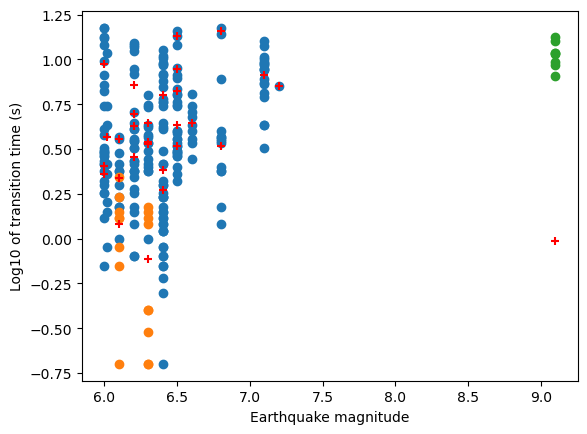

In [233]:
# plt.scatter(mcmc_array[:,3].astype(float), mcmc_array[:,9].astype(float)-10)
# plt.xlabel('Hypocentral distance (km)')
# plt.ylabel('Transition time (s)')
# plt.show()

plt.scatter(na_mcmc_array[:,1].astype(float), np.log10(na_mcmc_array[:,9].astype(float)-10), label = 'North America')
plt.scatter(taiwan_mcmc_array[:,1].astype(float), np.log10(taiwan_mcmc_array[:,9].astype(float)-10), label = 'Taiwan (dilatometers)')
plt.scatter(tohoku_mcmc_array[:,1].astype(float), np.log10(tohoku_mcmc_array[:,9].astype(float)-10), label = 'Tohoku')
plt.scatter(na_mags, np.log10(na_mean_trans_times), marker = '+', color = 'red', label = 'Mean transition time by event')
plt.scatter(taiwan_mags, np.log10(taiwan_mean_trans_times), marker = '+', color = 'red')
plt.scatter(tohoku_mags, np.log10(tohoku_mean_trans_times), marker = '+', color = 'red')
# plt.plot(mags_for_relation, np.log10(source_durs), color = 'lime', label = 'Source duration scaling')
# plt.plot(mags_for_relation, np.log10(rise_times), color = 'turquoise', label = 'Rise time scaling')
plt.xlabel('Earthquake magnitude')
plt.ylabel('Log10 of transition time (s)')
# plt.legend(loc = 'upper left');

# plt.scatter(na_mcmc_array[:,1].astype(float), np.log10(na_mcmc_array[:,9].astype(float)-10))
# plt.scatter(mags, np.log10(mean_trans_times), marker = '+', color = 'red', label = 'Mean transition time by event')
# # plt.plot(mags, mags * m + b, color = 'red', lw = 1)
# plt.plot(mcmc_array[:,1].astype(float), mcmc_array[:,1].astype(float) * ma + ba, color = 'C0', lw = 1)
# plt.plot(mags_for_relation, np.log10(source_durs), color = 'lime', label = 'Source duration scaling')
# plt.plot(mags_for_relation, np.log10(rise_times), color = 'turquoise', label = 'Rise time scaling')
# plt.xlabel('Earthquake magnitude')
# plt.ylabel('Log10 of transition time (s)')
# # plt.semilogy()
# plt.legend()
# plt.show()

# plt.scatter(mcmc_array[:,1].astype(float), mcmc_array[:,5].astype(float))
# plt.xlabel('Earthquake magnitude')
# plt.ylabel('Line 1 slope')
# plt.show()

# plt.scatter(mcmc_array[:,1].astype(float), mcmc_array[:,6].astype(float))
# plt.xlabel('Earthquake magnitude')
# plt.ylabel('Line 2 slope')
# plt.show()

In [11]:
pd_mcmc = pd.DataFrame(taiwan_mcmc_array, columns = ['eq_id', 'mag', 'sta', 'hypdist', 'xhigh', 'm1', 'm2', 'xinter', 'sigma', 'trans_time'])
pd_mcmc.to_csv(path + 'mcmc_arrays_uncal/mcmc_results_summary.csv', index = False)

In [12]:
# Figure out the "good" and "bad" performing waveforms using an L2 norm

mcmc_results = pd.read_csv(path + 'mcmc_arrays_uncal/mcmc_results_summary.csv')
mcmc_results

,eq_id,mag,sta,hypdist,xhigh,m1,m2,xinter,sigma,trans_time
0,2009-10-03_M6.1,6.1,NTTB,60,22,4.950249,0.103107,10.484332,0.097390,10.5
1,2009-10-03_M6.1,6.1,HGSB,15,22,3.838528,0.093399,10.887917,0.169596,10.9
2,2009-10-03_M6.1,6.1,ZANB,26,17,6.953588,0.106423,10.436389,0.171708,10.5
3,2009-10-03_M6.1,6.1,FBRB,56,29,1.828762,0.045035,11.322538,0.143003,11.4
4,2013-10-31_M6.3,6.3,TRKB,65,25,2.070050,0.068838,11.306140,0.189081,11.4
5,2013-10-31_M6.3,6.3,SJNB,59,25,2.152219,0.084941,11.213510,0.149279,11.3
6,2013-10-31_M6.3,6.3,HGSB,11,20,6.131144,0.083732,10.344852,0.124271,10.4
7,2013-10-31_M6.3,6.3,CHMB,11,20,10.009627,0.079016,10.196422,0.096045,10.2
8,2013-10-31_M6.3,6.3,SSNB,16,15,8.023050,0.254595,10.416833,0.112027,10.5
9,2013-10-31_M6.3,6.3,ZANB,21,20,16.250551,0.064077,10.177638,0.105708,10.2


In [18]:
print(np.mean(mcmc_results['m1'].values))
print(np.mean(mcmc_results['m2'].values))
print(np.mean(mcmc_results['xinter'].values))

print(np.median(mcmc_results['m1'].values))
print(np.median(mcmc_results['m2'].values))
print(np.median(mcmc_results['xinter'].values))

4.446746627339022
0.11814495924241208
10.919552479998195
2.077299920908816
0.0758330847134387
10.885281746944132
